测试数据和训练数据分组，数据分batch

In [1]:
import torch
from joblib import dump, load
import torch.utils.data as Data
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
# 参数与配置
torch.manual_seed(100)  # 设置随机种子，以使实验结果具有可重复性
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # 有GPU先用GPU训练

# 加载数据集
def dataloader(batch_size, workers=2):
    # 训练集
    train_xdata = load('train_xdata')
    train_ylabel = load('train_ylabel')
    # 验证集
    val_xdata = load('val_xdata')
    val_ylabel = load('val_ylabel')
    # 测试集
    test_xdata = load('test_xdata')
    test_ylabel = load('test_ylabel')

    # 加载数据
    train_loader = Data.DataLoader(dataset=Data.TensorDataset(train_xdata, train_ylabel),
                                   batch_size=batch_size, shuffle=True, num_workers=workers, drop_last=True)
    val_loader = Data.DataLoader(dataset=Data.TensorDataset(val_xdata, val_ylabel),
                                 batch_size=batch_size, shuffle=True, num_workers=workers, drop_last=True)
    test_loader = Data.DataLoader(dataset=Data.TensorDataset(test_xdata, test_ylabel),
                                  batch_size=batch_size, shuffle=True, num_workers=workers, drop_last=True)
    return train_loader, val_loader, test_loader

batch_size = 64
# 加载数据
train_loader, val_loader, test_loader = dataloader(batch_size)

print(len(train_loader))
print(len(val_loader))
print(len(test_loader))

111
31
15


In [2]:
print(len(train_loader))
print(len(val_loader))
print(len(test_loader))

111
31
15


定义CNN-LSTM 分类网络架构

In [3]:
# 定义 CNNLSTM 分类模型
class CNNLSTMclassifier(nn.Module):
    def __init__(self, input_dim, conv_archs,hidden_layer_sizes,output_dim, dropout_rate=0.5):
        """
        分类任务  params:
        input_dim        : 输入数据的维度
        conv_archs       : cnn 网络结构
        hidden_layer_size: lstm隐藏层的数目和维度
        output_dim       : 输出的维度
        dropout_rate     : 随机丢弃神经元的概率
        """
        super().__init__()
        # 批次量大小
        # CNN参数
        self.conv_arch = conv_archs # cnn网络结构
        self.input_channels = input_dim # 输入通道数
        self.cnn_features = self.make_layers()

        # lstm层数
        self.num_layers = len(hidden_layer_sizes)
        self.lstm_layers = nn.ModuleList()  # 用于保存LSTM层的列表

        # 定义第一层LSTM   
        self.lstm_layers.append(nn.LSTM(conv_archs[-1][-1], hidden_layer_sizes[0], batch_first=True))
        # 定义后续的LSTM层
        for i in range(1, self.num_layers):
                self.lstm_layers.append(nn.LSTM(hidden_layer_sizes[i-1], hidden_layer_sizes[i], batch_first=True))
        
          # 平局池化
        self.avgpool = nn.AdaptiveAvgPool1d(1)

        # 定义全连接层
        self.classifier = nn.Linear(hidden_layer_sizes[-1], output_dim)
    
     # CNN卷积池化结构
    def make_layers(self):
        layers = []
        for (num_convs, out_channels) in self.conv_arch:
            for _ in range(num_convs):
                layers.append(nn.Conv1d(self.input_channels, out_channels, kernel_size=3, padding=1))
                layers.append(nn.ReLU(inplace=True))
                self.input_channels = out_channels
            layers.append(nn.MaxPool1d(kernel_size=2, stride=2))
        return nn.Sequential(*layers)
    
    def forward(self, input_seq): 
        # CNN 卷积池化操作
        #改变输入形状，适应网络输入[batch,H_in, seq_length]
        batch_size = input_seq.size(0)
        input_seq = input_seq.view(batch_size, 1, 1024)
        cnn_features = self.cnn_features(input_seq) # torch.Size([64, 128, 128])

        # 送入LSTM层
        #改变输入形状，适应网络输入[batch, seq_length, H_in]
        lstm_out = torch.transpose(cnn_features, 1, 2)  # 反转维度 和序列长度 ，适应网络输入形状
        for lstm in self.lstm_layers:
            lstm_out, _= lstm(lstm_out)  ## 进行一次LSTM层的前向传播
        # print(lstm_out.size())  # torch.Size([64, 128, 64])
        x = self.avgpool(lstm_out.transpose(1, 2))  # B C 1  torch.Size([64, 64, 1])
        flat_tensor = x.reshape(batch_size, -1) # torch.Size([64, 64])
        out = self.classifier(flat_tensor) # torch.Size([64, 5] 
        return out


输入数据的形状是
 1. print(seq.size(), labels.size()) 
 2. torch.Size([32, 1024])    torch.Size([32])

In [4]:
# 定义模型参数
input_dim = 1  # 输入维度为1
conv_archs = ((1, 32), (1, 64), (1, 128))   # CNN 层卷积池化结构  类似VGG
hidden_layer_sizes = [128,64]  # LSTM 层数  每层 神经元个数
output_dim = 5  # 分类数

model = CNNLSTMclassifier(input_dim, conv_archs, hidden_layer_sizes, output_dim)  
# 定义损失函数和优化函数 
loss_function = nn.CrossEntropyLoss(reduction='sum')  # loss
learn_rate = 0.0003
optimizer = torch.optim.Adam(model.parameters(), learn_rate)  # 优化器

# 看下这个网络结构总共有多少个参数
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

count_parameters(model)

    96
    32
  6144
    64
 24576
   128
 65536
 65536
   512
   512
 32768
 16384
   256
   256
   320
     5
______
213125


In [5]:
print(model)

CNNLSTMclassifier(
  (cnn_features): Sequential(
    (0): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU(inplace=True)
    (2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (4): ReLU(inplace=True)
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (7): ReLU(inplace=True)
    (8): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (lstm_layers): ModuleList(
    (0): LSTM(128, 128, batch_first=True)
    (1): LSTM(128, 64, batch_first=True)
  )
  (avgpool): AdaptiveAvgPool1d(output_size=1)
  (classifier): Linear(in_features=64, out_features=5, bias=True)
)


In [ ]:
# 训练模型
# 训练模型
import time
import torch.nn.functional as F
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc("font", family='Microsoft YaHei')

def model_train(batch_size, epochs, model, optimizer, loss_function, train_loader, val_loader):
    model = model.to(device)
    # 样本长度
    train_size = len(train_loader) * batch_size
    val_size = len(val_loader) * batch_size

    # 最高准确率  最佳模型
    best_accuracy = 0.0
    best_model = model

    train_loss = []     # 记录在训练集上每个epoch的loss的变化情况
    train_acc = []    # 记录在训练集上每个epoch的准确率的变化情况
    validate_acc = []
    validate_loss = []

    # 计算模型运行时间
    start_time = time.time()
    for epoch in range(epochs):
        # 训练
        model.train()

        loss_epoch = 0.    #保存当前epoch的loss和
        correct_epoch = 0  #保存当前epoch的正确个数和
        for seq, labels in train_loader: 
            seq, labels = seq.to(device), labels.to(device)
            # print(seq.size(), labels.size()) torch.Size([32, 7, 1024]) torch.Size([32])
            # 每次更新参数前都梯度归零和初始化
            optimizer.zero_grad()
            # 前向传播
            y_pred = model(seq)  #   torch.Size([16, 10])
            # 对模型输出进行softmax操作，得到概率分布
            probabilities = F.softmax(y_pred, dim=1)
            # 得到预测的类别
            predicted_labels = torch.argmax(probabilities, dim=1)
            # 与真实标签进行比较，计算预测正确的样本数量  # 计算当前batch预测正确个数
            correct_epoch += (predicted_labels == labels).sum().item()
            # 损失计算
            loss = loss_function(y_pred, labels)
            loss_epoch += loss.item()
            # 反向传播和参数更新
            loss.backward()
            optimizer.step()
        #     break
        # break
        # 计算准确率
        train_Accuracy  = correct_epoch/train_size 
        train_loss.append(loss_epoch/train_size)
        train_acc.append(train_Accuracy)
        print(f'Epoch: {epoch+1:2} train_Loss: {loss_epoch/train_size:10.8f} train_Accuracy:{train_Accuracy:4.4f}')
        # 每一个epoch结束后，在验证集上验证实验结果。
        with torch.no_grad():
            # 将模型设置为评估模式
            model.eval()
            loss_validate = 0.
            correct_validate = 0
            for data, label in val_loader:
                data, label = data.to(device), label.to(device)
                pre = model(data)
                # 对模型输出进行softmax操作，得到概率分布
                probabilities = F.softmax(pre, dim=1)
                # 得到预测的类别
                predicted_labels = torch.argmax(probabilities, dim=1)
                # 与真实标签进行比较，计算预测正确的样本数量  # 计算当前batch预测正确个数
                correct_validate += (predicted_labels == label).sum().item()
                loss = loss_function(pre, label)
                loss_validate += loss.item()
            # print(f'validate_sum:{loss_validate},  validate_Acc:{correct_validate}')
            val_accuracy = correct_validate/val_size 
            print(f'Epoch: {epoch+1:2} val_Loss:{loss_validate/val_size:10.8f},  validate_Acc:{val_accuracy:4.4f}')
            validate_loss.append(loss_validate/val_size)
            validate_acc.append(val_accuracy)
            # 如果当前模型的准确率优于之前的最佳准确率，则更新最佳模型
            #保存当前最优模型参数
            if val_accuracy > best_accuracy:
                best_accuracy = val_accuracy
                best_model = model# 更新最佳模型的参数

    
    # 保存最后的参数
    # torch.save(model, 'final_model_cnn_lstm.pt')
    # 保存最好的参数
    torch.save(best_model, 'best_model_cnn_lstm.pt')
    
    print(f'\nDuration: {time.time() - start_time:.0f} seconds')
    plt.plot(range(epochs), train_loss, color = 'b',label = 'train_loss')
    plt.plot(range(epochs), train_acc, color = 'g',label = 'train_acc')
    plt.plot(range(epochs), validate_loss, color = 'y',label = 'validate_loss')
    plt.plot(range(epochs), validate_acc, color = 'r',label = 'validate_acc')
    plt.legend()
    plt.show()   #显示 lable 
    print("best_accuracy :", best_accuracy)



batch_size = 64
epochs = 50
# 模型训练
model_train(batch_size, epochs, model, optimizer, loss_function, train_loader, val_loader)

Epoch:  1 train_Loss: 1.61019607 train_Accuracy:0.1950
Epoch:  1 val_Loss:1.60965345,  validate_Acc:0.1925
Epoch:  2 train_Loss: 1.60986681 train_Accuracy:0.2037
Epoch:  2 val_Loss:1.60975847,  validate_Acc:0.1920
Epoch:  3 train_Loss: 1.60991083 train_Accuracy:0.1951
Epoch:  3 val_Loss:1.61011632,  validate_Acc:0.1920
Epoch:  4 train_Loss: 1.60974885 train_Accuracy:0.1857
Epoch:  4 val_Loss:1.60987233,  validate_Acc:0.1935
Epoch:  5 train_Loss: 1.60968477 train_Accuracy:0.1999
Epoch:  5 val_Loss:1.61032721,  validate_Acc:0.1910
Epoch:  6 train_Loss: 1.60929659 train_Accuracy:0.1997
Epoch:  6 val_Loss:1.60779785,  validate_Acc:0.1935
Epoch:  7 train_Loss: 1.60836535 train_Accuracy:0.2007
Epoch:  7 val_Loss:1.60746050,  validate_Acc:0.1915
Epoch:  8 train_Loss: 1.60954483 train_Accuracy:0.1968
Epoch:  8 val_Loss:1.60906326,  validate_Acc:0.1925
Epoch:  9 train_Loss: 1.60869524 train_Accuracy:0.2005
Epoch:  9 val_Loss:1.60938992,  validate_Acc:0.1930
Epoch: 10 train_Loss: 1.60847274 trai

In [11]:
from sklearn.metrics import confusion_matrix
import torch.nn.functional as F
# 模型 测试集 验证  
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # 有GPU先用GPU训练

# 得出每一类的分类准确率
model = torch.load('best_model_cnn_lstm.pt')
model = model.to(device)

# 使用测试集数据进行推断并计算每一类的分类准确率
class_labels = []  # 存储类别标签
predicted_labels = []  # 存储预测的标签

with torch.no_grad():
    for test_data, test_label in test_loader:
        # 将模型设置为评估模式
        model.eval()
        test_data = test_data.to(device)
        test_output = model(test_data)
        probabilities = F.softmax(test_output, dim=1)
        predicted = torch.argmax(probabilities, dim=1)
        
        class_labels.extend(test_label.tolist())
        predicted_labels.extend(predicted.tolist())

# 混淆矩阵
confusion_mat = confusion_matrix(class_labels, predicted_labels)

from sklearn.metrics import classification_report
# 计算每一类的分类准确率
report = classification_report(class_labels, predicted_labels, digits=4)
print(report)

              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000        13
           1     1.0000    1.0000    1.0000        21
           2     1.0000    0.9231    0.9600        26
           3     1.0000    1.0000    1.0000        31
           4     1.0000    1.0000    1.0000        26
           5     0.8529    0.9667    0.9062        30
           6     1.0000    0.8421    0.9143        19
           7     1.0000    1.0000    1.0000        27
           8     0.8000    0.8571    0.8276        14
           9     1.0000    1.0000    1.0000        17

    accuracy                         0.9643       224
   macro avg     0.9653    0.9589    0.9608       224
weighted avg     0.9678    0.9643    0.9648       224



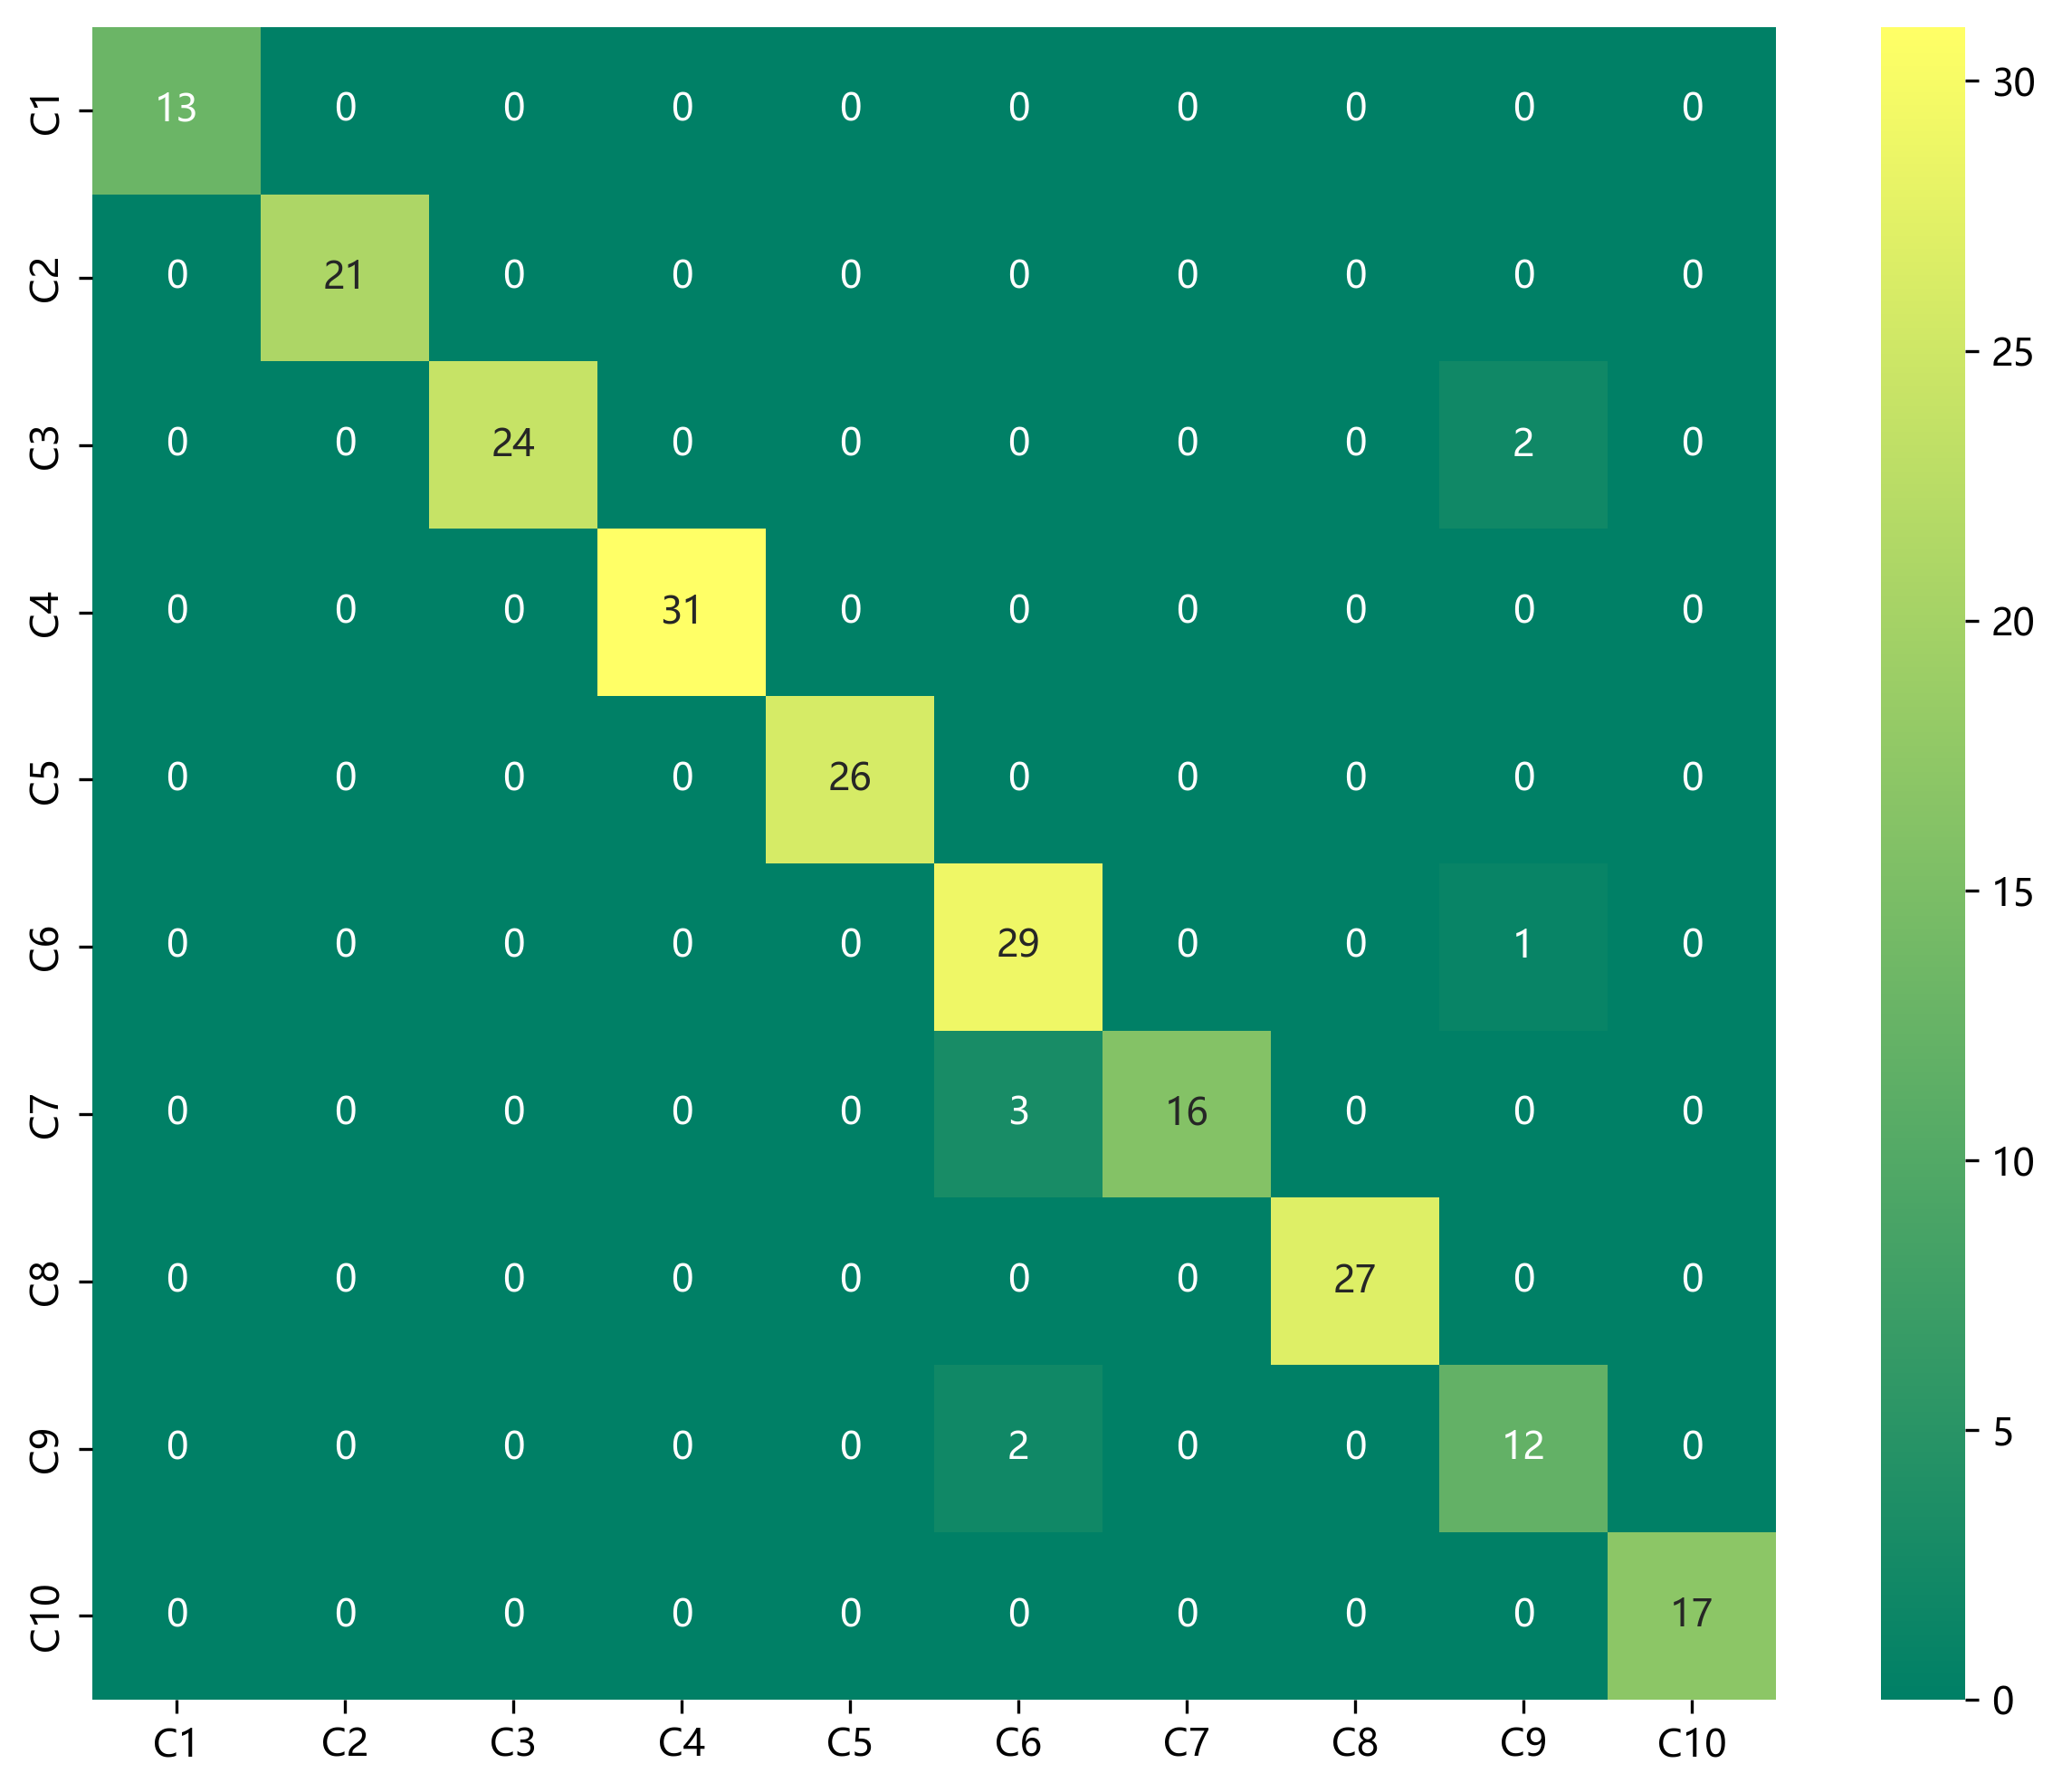

In [12]:
# 绘制混淆矩阵
import matplotlib.pyplot as plt
import seaborn as sns
# 原始标签和自定义标签的映射
label_mapping = {
    0: "C1",1: "C2",2: "C3",3: "C4",4: "C5",
}

# 绘制混淆矩阵
plt.figure(figsize=(10, 8), dpi=300)
sns.heatmap(confusion_mat,  xticklabels=label_mapping.values(), yticklabels=label_mapping.values(),annot=True, fmt='d', cmap='summer')
# plt.xlabel('Predicted Labels')
# plt.ylabel('True Labels')
# plt.title('Confusion Matrix')
plt.show()

Epoch 1/50
Train Loss: 0.6993 Acc: 0.6917
Val Loss: 0.6736 Acc: 0.7107

Epoch 2/50
Train Loss: 0.2639 Acc: 0.9071
Val Loss: 1.5369 Acc: 0.5469

Epoch 3/50
Train Loss: 0.1354 Acc: 0.9525
Val Loss: 0.2697 Acc: 0.8881

Epoch 4/50
Train Loss: 0.1025 Acc: 0.9633
Val Loss: 1.5224 Acc: 0.6486

Epoch 5/50
Train Loss: 0.0991 Acc: 0.9623
Val Loss: 0.3595 Acc: 0.8617

Epoch 6/50
Train Loss: 0.0460 Acc: 0.9778
Val Loss: 0.0954 Acc: 0.9399

Epoch 7/50
Train Loss: 0.0371 Acc: 0.9795
Val Loss: 0.0608 Acc: 0.9501

Epoch 8/50
Train Loss: 0.0434 Acc: 0.9771
Val Loss: 0.4113 Acc: 0.8695

Epoch 9/50
Train Loss: 0.0310 Acc: 0.9810
Val Loss: 0.5343 Acc: 0.8421

Epoch 10/50
Train Loss: 0.0291 Acc: 0.9830
Val Loss: 0.0615 Acc: 0.9482

Epoch 11/50
Train Loss: 0.0230 Acc: 0.9835
Val Loss: 0.0626 Acc: 0.9511

Epoch 12/50
Train Loss: 0.0287 Acc: 0.9838
Val Loss: 0.1144 Acc: 0.9360

Epoch 13/50
Train Loss: 0.0238 Acc: 0.9845
Val Loss: 0.3199 Acc: 0.8949

Epoch 14/50
Train Loss: 0.0271 Acc: 0.9838
Val Loss: 0.0573 

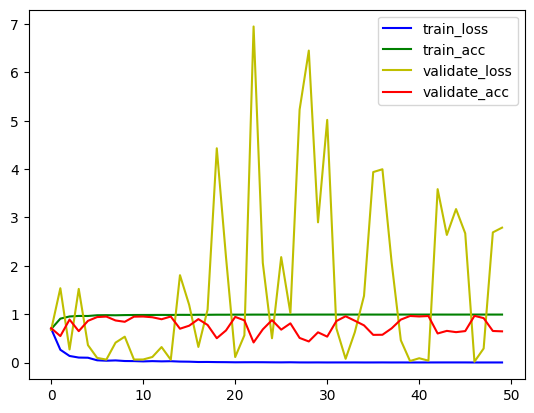

    96
    32
    32
    32
  3072
    32
    32
    32
  6144
    64
    64
    64
 12288
    64
    64
    64
 24576
   128
   128
   128
 49152
   128
   128
   128
131072
262144
  1024
  1024
131072
 65536
   512
   512
  8192
    64
   320
     5
______
698149
Best Validation Accuracy: 0.9653


In [8]:
import torch
from joblib import dump, load
import torch.utils.data as Data
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt


# 参数配置
torch.manual_seed(100)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 数据加载函数（添加归一化）
def dataloader(batch_size, workers=2):
    # 加载原始数据
    train_xdata = load('train_xdata')
    train_ylabel = load('train_ylabel')
    val_xdata = load('val_xdata')
    val_ylabel = load('val_ylabel')
    test_xdata = load('test_xdata')
    test_ylabel = load('test_ylabel')

    # 数据标准化
    data_mean = train_xdata.mean()
    data_std = train_xdata.std()
    
    def normalize(data):
        return (data - data_mean) / data_std

    # 转换数据格式
    train_xdata = torch.FloatTensor(normalize(train_xdata))
    train_ylabel = torch.LongTensor(train_ylabel)
    val_xdata = torch.FloatTensor(normalize(val_xdata))
    val_ylabel = torch.LongTensor(val_ylabel)
    test_xdata = torch.FloatTensor(normalize(test_xdata))
    test_ylabel = torch.LongTensor(test_ylabel)

    # 创建DataLoader
    train_loader = Data.DataLoader(Data.TensorDataset(train_xdata, train_ylabel),
                                  batch_size=batch_size, shuffle=True, 
                                  num_workers=workers, drop_last=True)
    val_loader = Data.DataLoader(Data.TensorDataset(val_xdata, val_ylabel),
                                batch_size=batch_size, shuffle=False,
                                num_workers=workers, drop_last=True)
    test_loader = Data.DataLoader(Data.TensorDataset(test_xdata, test_ylabel),
                                 batch_size=batch_size, shuffle=False,
                                 num_workers=workers, drop_last=True)
    return train_loader, val_loader, test_loader

# 改进的CNN-LSTM模型
class CNNLSTMclassifier(nn.Module):
    def __init__(self, input_dim, conv_archs, hidden_layer_sizes, output_dim, dropout_rate=0.3):
        super().__init__()
        # CNN部分
        self.conv_arch = conv_archs
        self.input_channels = input_dim
        self.cnn_features = self.make_conv_layers()
        
        # LSTM部分
        self.num_layers = len(hidden_layer_sizes)
        self.lstm_layers = nn.ModuleList()
        self.dropouts = nn.ModuleList()
        
        # 初始化LSTM层
        for i in range(self.num_layers):
            input_size = conv_archs[-1][1] if i == 0 else hidden_layer_sizes[i-1]
            self.lstm_layers.append(nn.LSTM(input_size, hidden_layer_sizes[i], batch_first=True))
            if i < self.num_layers - 1:
                self.dropouts.append(nn.Dropout(dropout_rate))
        
        # 分类层
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.classifier = nn.Sequential(
            nn.Linear(hidden_layer_sizes[-1], 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, output_dim)
        )

        # 初始化权重
        self._init_weights()

    def _init_weights(self):
        # CNN权重初始化
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            # LSTM权重初始化
            elif isinstance(m, nn.LSTM):
                for name, param in m.named_parameters():
                    if 'weight_ih' in name:
                        nn.init.xavier_normal_(param)
                    elif 'weight_hh' in name:
                        nn.init.orthogonal_(param)
                    elif 'bias' in name:
                        nn.init.constant_(param, 0)

    def make_conv_layers(self):
        layers = []
        in_channels = self.input_channels
        for (num_convs, out_channels) in self.conv_arch:
            for _ in range(num_convs):
                layers += [
                    nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1),
                    nn.BatchNorm1d(out_channels),
                    nn.ReLU(inplace=True)
                ]
                in_channels = out_channels
            layers.append(nn.MaxPool1d(kernel_size=2, stride=2))
        return nn.Sequential(*layers)

    def forward(self, x):
        batch_size = x.size(0)
        # CNN处理
        x = x.view(batch_size, 1, -1)  # [B, 1, 1024]
        cnn_features = self.cnn_features(x)  # [B, C, L]
        
        # LSTM处理
        lstm_input = cnn_features.permute(0, 2, 1)  # [B, L, C]
        for i in range(self.num_layers):
            lstm_input, _ = self.lstm_layers[i](lstm_input)
            if i < self.num_layers - 1:
                lstm_input = self.dropouts[i](lstm_input)
        
        # 分类处理
        x = self.avgpool(lstm_input.permute(0, 2, 1))  # [B, C, 1]
        x = x.view(batch_size, -1)
        return self.classifier(x)

# 训练函数优化
def model_train(batch_size, epochs, model, optimizer, loss_function, train_loader, val_loader):
    model = model.to(device)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=3, factor=0.5)
    
    best_accuracy = 0.0
    train_loss, train_acc = [], []
    validate_loss, validate_acc = [], []

    for epoch in range(epochs):
        # 训练阶段
        model.train()
        epoch_loss = 0.0
        correct = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            
            loss.backward()
            # 梯度裁剪
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            
            epoch_loss += loss.item() * inputs.size(0)
            preds = torch.argmax(outputs, 1)
            correct += (preds == labels).sum().item()
        
        # 验证阶段
        model.eval()
        val_loss = 0.0
        val_correct = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                val_loss += loss_function(outputs, labels).item() * inputs.size(0)
                preds = torch.argmax(outputs, 1)
                val_correct += (preds == labels).sum().item()
        
        # 计算指标
        train_epoch_loss = epoch_loss / len(train_loader.dataset)
        train_epoch_acc = correct / len(train_loader.dataset)
        val_epoch_loss = val_loss / len(val_loader.dataset)
        val_epoch_acc = val_correct / len(val_loader.dataset)
        
        # 更新学习率
        scheduler.step(val_epoch_acc)
        
        # 记录指标
        train_loss.append(train_epoch_loss)
        train_acc.append(train_epoch_acc)
        validate_loss.append(val_epoch_loss)
        validate_acc.append(val_epoch_acc)
        
        # 保存最佳模型
        if val_epoch_acc > best_accuracy:
            best_accuracy = val_epoch_acc
            torch.save(model, 'best_model_cnn_lstm.pt')
        
        print(f'Epoch {epoch+1}/{epochs}')
        print(f'Train Loss: {train_epoch_loss:.4f} Acc: {train_epoch_acc:.4f}')
        print(f'Val Loss: {val_epoch_loss:.4f} Acc: {val_epoch_acc:.4f}\n')
    
    #print(f'\nDuration: {time.time() - start_time:.0f} seconds')
    plt.plot(range(epochs), train_loss, color = 'b',label = 'train_loss')
    plt.plot(range(epochs), train_acc, color = 'g',label = 'train_acc')
    plt.plot(range(epochs), validate_loss, color = 'y',label = 'validate_loss')
    plt.plot(range(epochs), validate_acc, color = 'r',label = 'validate_acc')
    plt.legend()
    plt.show()   #显示 lable 

    def count_parameters(model):
        params = [p.numel() for p in model.parameters() if p.requires_grad]
        for item in params:
            print(f'{item:>6}')
        print(f'______\n{sum(params):>6}')
        print(f'Best Validation Accuracy: {best_accuracy:.4f}')
    count_parameters(model)

# 参数配置
batch_size = 64
epochs = 50
input_dim = 1
conv_archs = ((2, 32), (2, 64), (2, 128))  # 改进的CNN结构
hidden_layer_sizes = [256, 128]            # 增强LSTM容量
output_dim = 5

# 初始化模型
model = CNNLSTMclassifier(input_dim, conv_archs, hidden_layer_sizes, output_dim)
loss_function = nn.CrossEntropyLoss(reduction='mean')  # 修正损失函数
learn_rate = 0.001
optimizer = torch.optim.AdamW(model.parameters(), lr=learn_rate, weight_decay=1e-4)

# 加载数据
train_loader, val_loader, test_loader = dataloader(batch_size)

# 开始训练
model_train(batch_size, epochs, model, optimizer, loss_function, train_loader, val_loader)

In [13]:
from sklearn.metrics import confusion_matrix
import torch.nn.functional as F
# 模型 测试集 验证  
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # 有GPU先用GPU训练

# 得出每一类的分类准确率
model = torch.load('best_model_cnn_lstm.pt')
model = model.to(device)

# 使用测试集数据进行推断并计算每一类的分类准确率
class_labels = []  # 存储类别标签
predicted_labels = []  # 存储预测的标签

with torch.no_grad():
    #for test_data, test_label in test_loader:
    for test_data, test_label in test_loader:
        # 将模型设置为评估模式
        model.eval()
        test_data = test_data.to(device)
        test_output = model(test_data)
        probabilities = F.softmax(test_output, dim=1)
        predicted = torch.argmax(probabilities, dim=1)
        
        class_labels.extend(test_label.tolist())
        predicted_labels.extend(predicted.tolist())

# 混淆矩阵
confusion_mat = confusion_matrix(class_labels, predicted_labels)

from sklearn.metrics import classification_report
# 计算每一类的分类准确率
report = classification_report(class_labels, predicted_labels, digits=4)
print(report)

C:\Users\Administrator\AppData\Local\Temp\ipykernel_21132\1448011076.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('best_model_cnn_lstm.pt')


              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       197
           1     1.0000    0.9947    0.9973       188
           2     1.0000    1.0000    1.0000       190
           3     0.9896    0.9896    0.9896       192
           4     0.9897    0.9948    0.9922       193

    accuracy                         0.9958       960
   macro avg     0.9959    0.9958    0.9958       960
weighted avg     0.9958    0.9958    0.9958       960



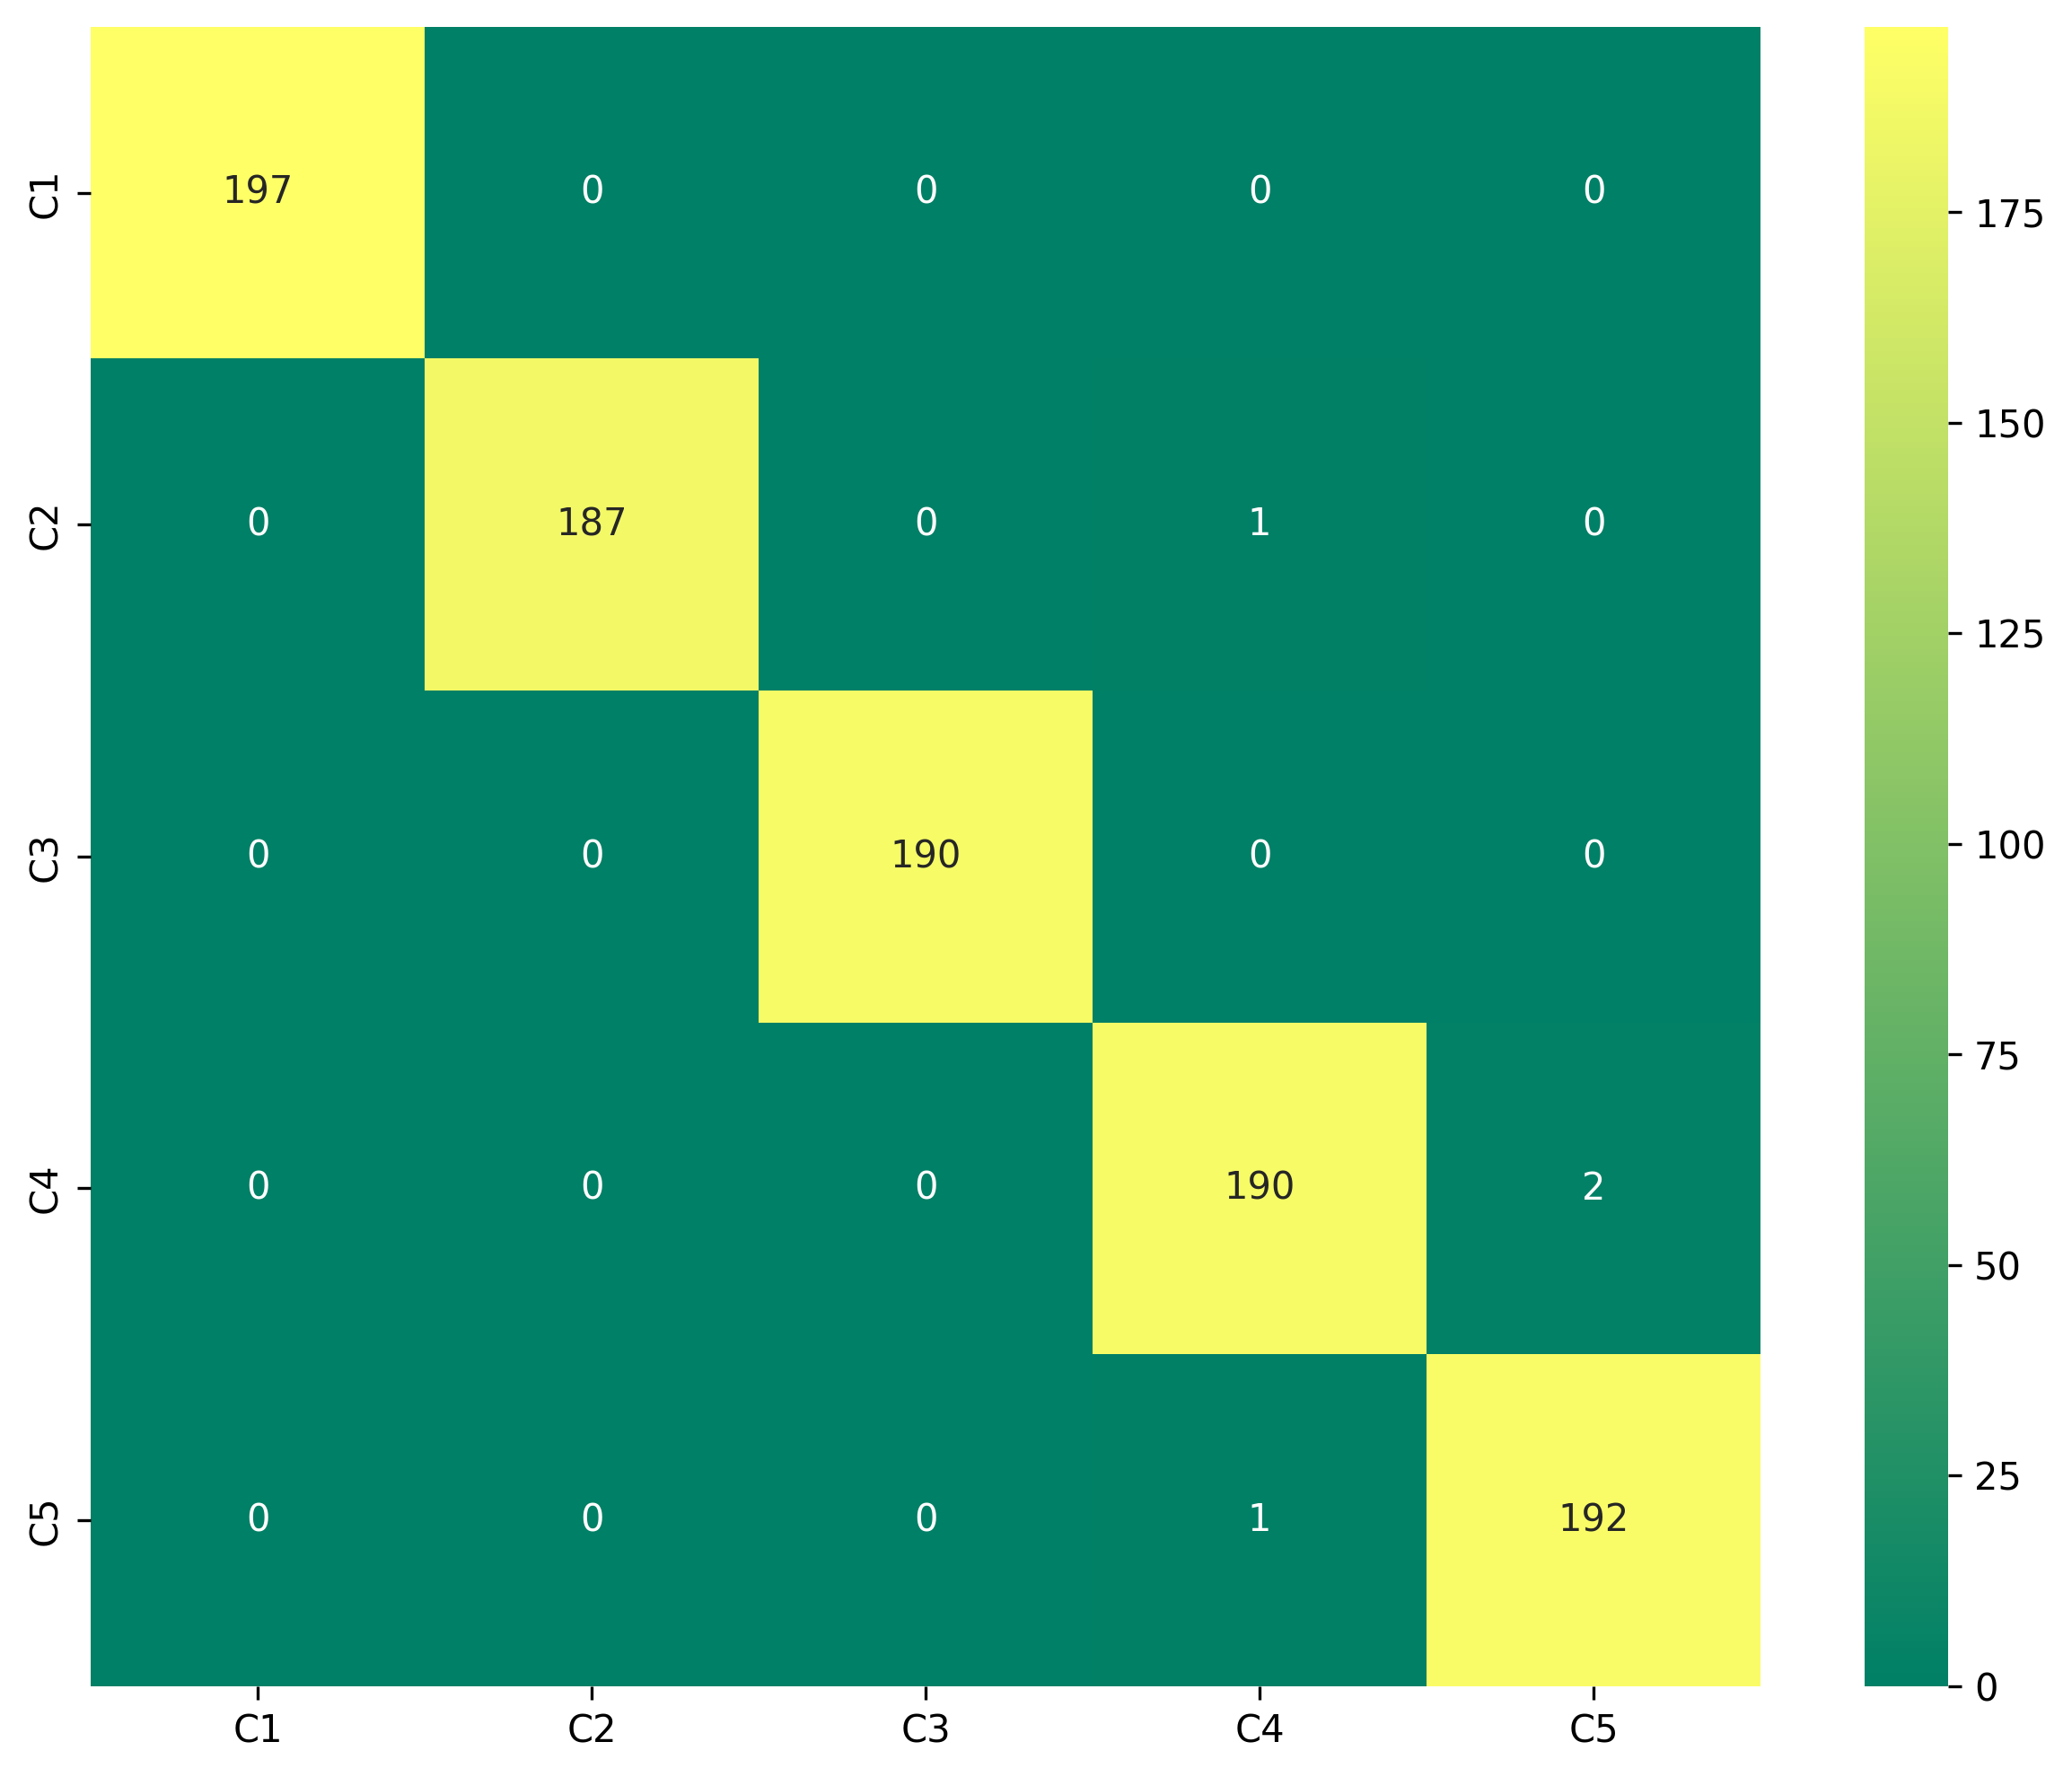

In [10]:
# 绘制混淆矩阵
import matplotlib.pyplot as plt
import seaborn as sns
# 原始标签和自定义标签的映射
label_mapping = {
    0: "C1",1: "C2",2: "C3",3: "C4",4: "C5",
    
}

# 绘制混淆矩阵
plt.figure(figsize=(10, 8), dpi=300)
sns.heatmap(confusion_mat,  xticklabels=label_mapping.values(), yticklabels=label_mapping.values(),annot=True, fmt='d', cmap='summer')
# plt.xlabel('Predicted Labels')
# plt.ylabel('True Labels')
# plt.title('Confusion Matrix')
plt.show()

In [ ]:
# 绘制混淆矩阵
import matplotlib.pyplot as plt
import seaborn as sns
# 原始标签和自定义标签的映射
label_mapping = {
    0: "C1",1: "C2",2: "C3",3: "C4",4: "C5",
}

# 绘制混淆矩阵
plt.figure(figsize=(10, 8), dpi=300)
sns.heatmap(confusion_mat,  xticklabels=label_mapping.values(), yticklabels=label_mapping.values(),annot=True, fmt='d', cmap='summer')
# plt.xlabel('Predicted Labels')
# plt.ylabel('True Labels')
# plt.title('Confusion Matrix')
plt.show()